In [77]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy.optimize import curve_fit
from lmfit import Minimizer, Parameters, report_fit
import seaborn as sns

sns.set(color_codes=True, style="white")

### Load Data

In [78]:
folder = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-in-HOPS_condensates/paper_figure_plots/interaction_kinetics_mRNA"
label1 = "FL, 2x, -"
label2 = "FL, 2x, +puro"
fname1 = "colocalization_AIO_concat-FL_2x.csv"
fname2 = "colocalization_AIO_concat-FL_puro_2x.csv"
color_1 = "#FF6B6B"
color_2 = "#B30000"
palette = [color_1, color_2]
os.chdir(folder)

In [79]:
df1 = pd.read_csv(fname1)
df2 = pd.read_csv(fname2)

### Functions

In [115]:
def get_dwell_times(array_in_condensate, array_trackID):
    # Find the indices where the array changes from False to True or vice versa
    change_indices_condensate = (
        np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
    )

    # Find the indices where the trackID changes
    change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1

    # Combine the change indices from both arrays
    change_indices = np.unique(
        np.concatenate((change_indices_condensate, change_indices_trackID))
    )

    # Add the start and end indices to the change_indices array
    change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))

    # Calculate the durations of each True event
    dwell_times = []
    for i in range(len(change_indices) - 1):
        if array_in_condensate[change_indices[i]]:
            dwell_times.append(change_indices[i + 1] - change_indices[i])

    return np.array(dwell_times)


def calc_R2(ydata, yfit):
    # residual sum of squares (ss_tot)
    residuals = ydata - yfit
    ss_res = np.sum(residuals**2)
    # total sum of squares (ss_tot)
    ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
    # r_squared-value
    r_squared = 1 - (ss_res / ss_tot)

    return r_squared


def cdf_lmfit_dual(params, t, data):
    # define objective function: returns the array to be minimized
    """Model a decaying sine wave and subtract data."""
    a1 = params["a1"]
    a2 = params["a2"]
    tau1 = params["tau1"]
    tau2 = params["tau2"]
    model = 1 - a1 * np.exp(-t / tau1) - a2 * np.exp(-t / tau2)
    return model - data


def cdf_lmfit_single(params, t, data):
    # define objective function: returns the array to be minimized
    """Model a decaying sine wave and subtract data."""
    a1 = params["a1"]
    tau1 = params["tau1"]
    model = 1 - a1 * np.exp(-t / tau1)
    return model - data


def fit_CDF_dual(dwell_times):
    bins = 100
    binrange = (0.1, 3)
    hist, bin_edges = np.histogram(dwell_times, bins=bins, range=binrange, density=True)
    cumulative_hist = np.cumsum(hist) / np.sum(hist)  # Convert the histogram to CDF
    bin_centers = bin_edges[:-1] + binrange[-1] / bins
    # bin_centers = bin_edges[:-1]

    # create a set of Parameters
    params = Parameters()
    params.add("a1", min=0, max=1, value=0)
    params.add("a2", expr="1-a1")
    params.add("tau1", min=0.03, max=0.5, value=0.1)  # min=ln2/0.1
    params.add("tau2", min=0.5, max=2, value=1)

    # do fit, with the default leastsq algorithm
    minner = Minimizer(cdf_lmfit_dual, params, fcn_args=(bin_centers, cumulative_hist))
    result = minner.minimize()

    a1 = result.params["a1"].value
    a2 = result.params["a2"].value
    tau1 = result.params["tau1"].value
    tau2 = result.params["tau2"].value
    a1_se = result.params["a1"].stderr
    a2_se = result.params["a2"].stderr
    tau1_se = result.params["tau1"].stderr
    tau2_se = result.params["tau2"].stderr

    xdata = bin_centers
    ydata = cumulative_hist
    yfit = cumulative_hist + result.residual
    R2 = calc_R2(ydata, yfit)

    # report_fit(result)
    print("a1", a1, a1_se)
    print("tau1", tau1, tau1_se)
    print("a2", a2, a2_se)
    print("tau2", tau2, tau2_se)

    return {
        "a1": a1,
        "a2": a2,
        "tau1": tau1,
        "tau2": tau2,
        "a1_se": a1_se,
        "a2_se": a2_se,
        "tau1_se": tau1_se,
        "tau2_se": tau2_se,
        "xdata": xdata,
        "ydata": ydata,
        "bin_centers": bin_centers,
        "yfit": yfit,
        "R2": R2,
    }


def fit_CDF_single(dwell_times):
    bins = 100
    binrange = (0.1, 3)
    hist, bin_edges = np.histogram(dwell_times, bins=bins, range=binrange, density=True)
    cumulative_hist = np.cumsum(hist) / np.sum(hist)  # Convert the histogram to CDF
    bin_centers = bin_edges[:-1] + binrange[-1] / bins
    # bin_centers = bin_edges[:-1]

    # create a set of Parameters
    params = Parameters()
    params.add("a1", min=0, max=1, value=0.8)
    params.add("tau1", min=0.03, max=2, value=1)  # min=ln2/0.1

    # do fit, with the default leastsq algorithm
    minner = Minimizer(
        cdf_lmfit_single, params, fcn_args=(bin_centers, cumulative_hist)
    )
    result = minner.minimize()

    a1 = result.params["a1"].value
    tau1 = result.params["tau1"].value
    a1_se = result.params["a1"].stderr
    tau1_se = result.params["tau1"].stderr

    xdata = bin_centers
    ydata = cumulative_hist
    yfit = cumulative_hist + result.residual
    R2 = calc_R2(ydata, yfit)

    # report_fit(result)
    print("a1", a1, a1_se)
    print("tau1", tau1, tau1_se)

    return {
        "a1": a1,
        "tau1": tau1,
        "a1_se": a1_se,
        "tau1_se": tau1_se,
        "xdata": xdata,
        "ydata": ydata,
        "bin_centers": bin_centers,
        "yfit": yfit,
        "R2": R2,
    }

### Dwell time distributions

In [93]:
dwell_times_1 = (
    get_dwell_times(df1["InCondensate"].to_numpy(), df1["RNA_trackID"].to_numpy()) * 0.1
)  # unit s
dwell_times_2 = (
    get_dwell_times(df2["InCondensate"].to_numpy(), df2["RNA_trackID"].to_numpy()) * 0.1
)  # unit s
data = pd.concat(
    [
        pd.DataFrame({"dwell_time": dwell_times_1, "label": label1}),
        pd.DataFrame({"dwell_time": dwell_times_2, "label": label2}),
    ],
    ignore_index=True,
)

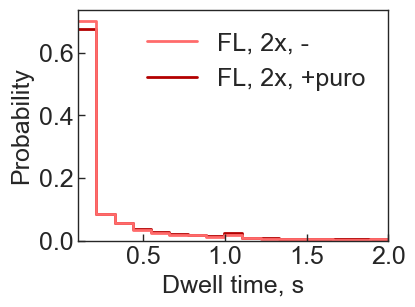

In [82]:
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=data,
    x="dwell_time",
    hue="label",
    palette=palette,
    bins=17,
    binrange=(0.1, 3),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    # cumulative=True,
)
plt.xlim(0.1, 3)
sns.move_legend(ax, 1, title=None, frameon=False, fontsize=18)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "dwell-histo.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

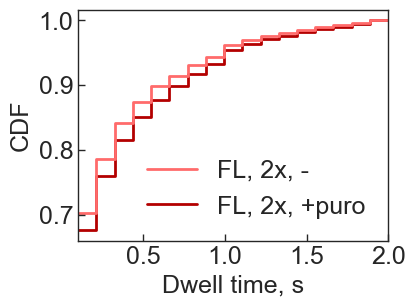

In [83]:
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=data,
    x="dwell_time",
    hue="label",
    palette=palette,
    bins=17,
    binrange=(0.1, 3),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    cumulative=True,
)
plt.xlim(0.1, 3)
sns.move_legend(
    ax,
    4,
    title=None,
    frameon=False,
    fontsize=18,
)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("CDF", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "dwell-cdf.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### Fit to CDF

In [116]:
dwell_times_1 = (
    get_dwell_times(df1["InCondensate"].to_numpy(), df1["RNA_trackID"].to_numpy()) * 0.1
)  # unit s
dwell_times_2 = (
    get_dwell_times(df2["InCondensate"].to_numpy(), df2["RNA_trackID"].to_numpy()) * 0.1
)  # unit s

In [117]:
print(label1)
results_dual_1 = fit_CDF_dual(dwell_times_1)
results_single_1 = fit_CDF_single(dwell_times_1)

FL, 2x, -
a1 0.7312617621530586 0.021681485780231335
tau1 0.14383458267247243 0.0061806794457305
a2 0.2687382378469414 0.021681485826740773
tau2 0.6904613639131003 0.04547124906577888
a1 0.6267336374598079 0.020189966384515257
tau1 0.39363789460065024 0.01351476310314746


In [118]:
print(label2)
results_dual_2 = fit_CDF_dual(dwell_times_2)
results_single_2 = fit_CDF_single(dwell_times_2)

FL, 2x, +puro
a1 0.6658717477085216 0.025668896144075023
tau1 0.13969077283604103 0.007288286232990109
a2 0.33412825229147836 0.025668896110520593
tau2 0.6923811430619744 0.03774594982183236
a1 0.62088313711827 0.017232822698696273
tau1 0.44992182234741074 0.013763988327429266


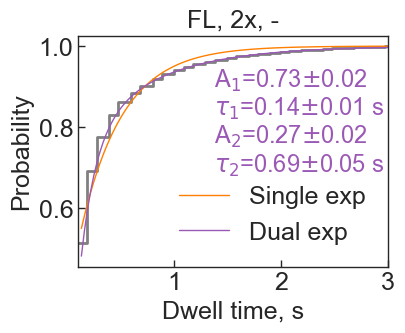

In [130]:
# For first dataset
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=dwell_times_1,
    color="gray",
    bins=100,
    binrange=(0.1, 3),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    cumulative=True,
)
# plot single fit
plt.plot(
    results_single_1["bin_centers"],
    results_single_1["yfit"],
    color="#FF7F00",
    linestyle="-",
    label="Single exp",
    lw=1,
)
# plot dual fit
plt.plot(
    results_dual_1["bin_centers"],
    results_dual_1["yfit"],
    color="#9B59B6",
    linestyle="-",
    label="Dual exp",
    lw=1,
)
# add text
left = 1.37
top = 0.9
gap = 0.07
plt.text(
    left,
    top,
    "A$_1$="
    + "{:.2f}".format(round(results_dual_1["a1"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_1["a1_se"], 2)),
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 1,
    r"$\tau_1$="
    + "{:.2f}".format(round(results_dual_1["tau1"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_1["tau1_se"], 2))
    + " s",
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 2,
    "A$_2$="
    + "{:.2f}".format(round(results_dual_1["a2"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_1["a2_se"], 2)),
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 3,
    r"$\tau_2$="
    + "{:.2f}".format(round(results_dual_1["tau2"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_1["tau2_se"], 2))
    + " s",
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
# adjust other param
plt.legend(frameon=False, loc=4, fontsize=18)
plt.xlim(0.1, 3)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.title(label1, fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "compare_exp_fits-FL_2x.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

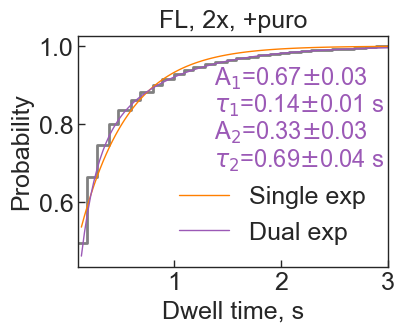

In [129]:
# For second dataset
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=dwell_times_2,
    color="gray",
    bins=100,
    binrange=(0.1, 3),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    cumulative=True,
)
# plot single fit
plt.plot(
    results_single_2["bin_centers"],
    results_single_2["yfit"],
    color="#FF7F00",
    linestyle="-",
    label="Single exp",
    lw=1,
)
# plot dual fit
plt.plot(
    results_dual_2["bin_centers"],
    results_dual_2["yfit"],
    color="#9B59B6",
    linestyle="-",
    label="Dual exp",
    lw=1,
)
# add text
left = 1.37
top = 0.9
gap = 0.07
plt.text(
    left,
    top,
    "A$_1$="
    + "{:.2f}".format(round(results_dual_2["a1"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_2["a1_se"], 2)),
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 1,
    r"$\tau_1$="
    + "{:.2f}".format(round(results_dual_2["tau1"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_2["tau1_se"], 2))
    + " s",
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 2,
    "A$_2$="
    + "{:.2f}".format(round(results_dual_2["a2"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_2["a2_se"], 2)),
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
plt.text(
    left,
    top - gap * 3,
    r"$\tau_2$="
    + "{:.2f}".format(round(results_dual_2["tau2"], 2))
    + r"$\pm$"
    + "{:.2f}".format(round(results_dual_2["tau2_se"], 2))
    + " s",
    fontsize=17,
    color="#9B59B6",
    horizontalalignment="left",
)
# adjust other param
plt.legend(frameon=False, loc=4, fontsize=18)
plt.xlim(0.1, 3)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.title(label2, fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "compare_exp_fits-FL_2x_puro.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)